# preprocessing achilles

In [209]:
from __future__ import print_function
import pandas as pd
import numpy as np
import sys

sys.path.insert(0, '..')

from src.CCLE_postp_function import *
from JKBio import terra
from JKBio.utils import helper as h
from JKBio.google import gcp
from gsheets import Sheets
from taigapy import TaigaClient
import dalmatian as dm
from JKBio.google.google_sheet import dfToSheet

from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import pearsonr,spearmanr

from bokeh.plotting import *
from bokeh.models import HoverTool
from collections import OrderedDict
from IPython.display import Image,display
from matplotlib import pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython
tc = TaigaClient()
output_notebook()

my_id = '~/.client_secret.json'
mystorage_id = "~/.storage.json"
# do the first steps of https://medium.com/craftsmenltd/from-csv-to-google-sheet-using-python-ef097cb014f9
creds = '../.credentials.json'

sheets = Sheets.from_files(my_id, mystorage_id)
replace = {'T': 'Tumor', 'N': 'Normal', 'm': 'Unknown', 'L': 'Unknown'}

refsheet_url = "https://docs.google.com/spreadsheets/d/1Pgb5fIClGnErEqzxpU7qqX6ULpGTDjvzWwDN8XUJKIY"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Loading BokehJS ...

## boot up

we are instanciating all the parameters needed for this pipeline to run

In [174]:
samplesetname = "21Q1"
release=samplesetname

## Do some checks and manual rescuing

In [210]:
ccle_refsamples = sheets.get(refsheet_url).sheets[0].to_frame(index_col=0)

In [175]:
legacy_segments = tc.get(name='depmap-wes-cn-data--08f3', file='legacy_segments')
legacy_segments = legacy_segments.drop(columns='Unnamed: 0')
legacy_segments['Status']='U'

prevgenecn = (2**tc.get(name='depmap-a0ab', file='CCLE_gene_cn'))-1 
prevsegments = tc.get(name='depmap-a0ab', file='CCLE_segment_cn')
#prevgenecn = (2**tc.get(name='internal-20q3-00d0', file='CCLE_gene_cn'))-1 
prev = prevgenecn.index.tolist()

In [202]:
priosegments = pd.read_csv("temp/segments_allWES_latest_"+samplesetname+".csv")
#priogenecn = pd.read_csv('temp/gene_cn_allWES_latest_'+samplesetname+".csv", index_col=0)

In [198]:
cyto = pd.read_csv('data/hg38_cytoband.gz', sep='\t',names=['chrom', 'start', 'end','loc','stains'])
cyto['chrom'] = [i[3:] for i in cyto['chrom']]
gene_mapping = pd.read_csv('data/genemapping_19Q1.csv')

In [199]:
priosegments = manageGapsInSegments(priosegments, cyto=cyto)

In [243]:
onlyinleg = set(legacy_segments.DepMap_ID) - set(priosegments.DepMap_ID)
samegenes = set(prevgenecn.columns) & set(priogenecn.columns)
onlyinleg

{'ACH-000003',
 'ACH-000014',
 'ACH-000016',
 'ACH-000034',
 'ACH-000044',
 'ACH-000049',
 'ACH-000057',
 'ACH-000064',
 'ACH-000068',
 'ACH-000071',
 'ACH-000088',
 'ACH-000164',
 'ACH-000170',
 'ACH-000179',
 'ACH-000185',
 'ACH-000194',
 'ACH-000195',
 'ACH-000216',
 'ACH-000229',
 'ACH-000230',
 'ACH-000299',
 'ACH-000300',
 'ACH-000306',
 'ACH-000333',
 'ACH-000413',
 'ACH-000454',
 'ACH-000479',
 'ACH-000494',
 'ACH-000526',
 'ACH-000539',
 'ACH-000550',
 'ACH-000575',
 'ACH-000578',
 'ACH-000600',
 'ACH-000612',
 'ACH-000632',
 'ACH-000635',
 'ACH-000642',
 'ACH-000659',
 'ACH-000690',
 'ACH-000705',
 'ACH-000710',
 'ACH-000731',
 'ACH-000737',
 'ACH-000739',
 'ACH-000742',
 'ACH-000842',
 'ACH-000850',
 'ACH-000854',
 'ACH-000870',
 'ACH-000901',
 'ACH-000904',
 'ACH-000923',
 'ACH-000928',
 'ACH-000931',
 'ACH-000982',
 'ACH-001000',
 'ACH-001015',
 'ACH-001017',
 'ACH-001018',
 'ACH-001036',
 'ACH-001037',
 'ACH-001042',
 'ACH-001043',
 'ACH-001044',
 'ACH-001045',
 'ACH-0010

In [253]:
bad = ["ACH-001011",
"ACH-001108",
"ACH-001187",
"ACH-001189",
"ACH-002303",
"ACH-002315",
"ACH-001956",
"ACH-001955",
"ACH-001957",
"ACH-002341"]

In [254]:
onlyinleg = onlyinleg - set(bad)

In [ ]:
"ACH-000274",
"ACH-002446",
"ACH-000833",
"ACH-001151",
"ACH-001955",
"ACH-000757",
"ACH-000511",
"ACH-001321",
"ACH-000473",
"ACH-001605",
"ACH-001957",

In [255]:
for val in onlyinleg:
    print(val,legacy_segments[legacy_segments.DepMap_ID==val].Source.values[0])

ACH-000578 Broad SNP
ACH-001000 Broad SNP
ACH-001071 Broad SNP
ACH-000742 Broad SNP
ACH-000170 Broad SNP
ACH-000842 Broad SNP
ACH-000737 Broad SNP
ACH-002217 Sanger WES
ACH-000229 Broad SNP
ACH-001043 Broad SNP
ACH-001230 Broad SNP
ACH-002378 Sanger WES
ACH-000705 Broad SNP
ACH-000870 Broad SNP
ACH-001171 Broad SNP
ACH-000195 Broad SNP
ACH-000194 Broad SNP
ACH-001234 Broad SNP
ACH-000016 Broad SNP
ACH-001037 Broad SNP
ACH-000982 Broad SNP
ACH-001225 Broad SNP
ACH-000632 Broad SNP
ACH-000710 Broad SNP
ACH-000635 Broad SNP
ACH-000731 Broad SNP
ACH-000600 Broad SNP
ACH-001088 Broad SNP
ACH-001214 Broad SNP
ACH-000479 Broad SNP
ACH-000690 Broad SNP
ACH-001121 Broad SNP
ACH-001175 Broad SNP
ACH-000164 Broad SNP
ACH-000454 Broad SNP
ACH-000739 Broad SNP
ACH-001146 Broad SNP
ACH-000854 Broad SNP
ACH-001188 Broad SNP
ACH-001207 Broad SNP
ACH-001017 Broad SNP
ACH-000931 Broad SNP
ACH-000057 Broad SNP
ACH-001198 Broad SNP
ACH-000333 Broad SNP
ACH-000494 Broad SNP
ACH-000044 Broad SNP
ACH-000068 

In [218]:
priogenecn.shape

(1694, 27562)

In [ ]:
## only gettinng good correlation samples

## Achilles repriorization

In [247]:
corr = {}
ge = np.log2(1+priogenecn[samegenes])
pre = np.log2(1+prevgenecn[samegenes]).fillna(0)
for sample in set(prevgenecn.index) & set(priogenecn.index):
        corr[sample] = pearsonr(ge.loc[sample],pre.loc[sample])[0]   

In [250]:
toreplace = []
for k, val in corr.items():
    if val<0.85:
        toreplace.append(k)

In [251]:
len(toreplace)/len(corr)

0.07720144752714113

<AxesSubplot:>

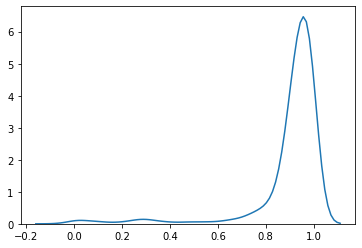

In [257]:
a = np.array(list(corr.values()))
sns.kdeplot(a)

<AxesSubplot:>

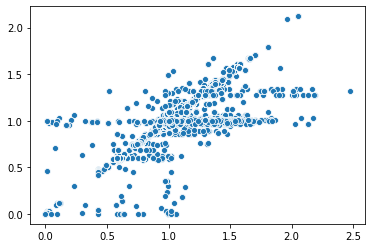

In [260]:
ind = set(prevgenecn.index) & set(priogenecn.index)
sns.scatterplot(x=ge.loc[ind].values.ravel()[:100000],y=pre.loc[ind].values.ravel()[:100000],)

/home/jeremie/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)
/home/jeremie/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:423: UserWarning: The following kwargs were not used by contour: 'fill'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


<AxesSubplot:>

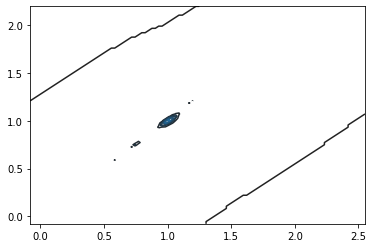

In [261]:
sns.kdeplot(data=np.array([ge.loc[ind].values.ravel()[:100000], pre.loc[ind].values.ravel()[:100000]]).T, fill=True)

In [340]:
#mergedsegments = priosegments[~priosegments.DepMap_ID.isin(toreplace)].append(legacy_segments[legacy_segments.DepMap_ID.isin(toreplace)]).reset_index(drop=True)
mergedsegments = priosegments

In [341]:
mergedsegments = mergedsegments.append(legacy_segments[legacy_segments.DepMap_ID.isin(list(onlyinleg))]).reset_index(drop=True)

### Adding WGS

In [381]:
wgssegments = pd.read_csv("temp/segments_allWGS_latest_"+samplesetname+".csv")
#wgssegments = pd.read_csv("temp/segments_allWGS_latest_"+samplesetname+".csv")

In [382]:
wgssegments.Segment_Mean.max()

1064.007791437255

In [383]:
wgssegments = manageGapsInSegments(wgssegments, cyto=cyto)

In [384]:
mergedsegments = wgssegments.append(mergedsegments[~mergedsegments.DepMap_ID.isin(set(wgssegments.DepMap_ID))])

In [278]:
lost = set(["ACH-002217",
"ACH-002335",
"ACH-002378"])

In [280]:
#only in snp
onlyinleg - ( lost | set(wgssegments.DepMap_ID))

{'ACH-000003',
 'ACH-000016',
 'ACH-000034',
 'ACH-000049',
 'ACH-000057',
 'ACH-000064',
 'ACH-000071',
 'ACH-000088',
 'ACH-000170',
 'ACH-000185',
 'ACH-000194',
 'ACH-000216',
 'ACH-000229',
 'ACH-000230',
 'ACH-000299',
 'ACH-000300',
 'ACH-000306',
 'ACH-000333',
 'ACH-000413',
 'ACH-000494',
 'ACH-000526',
 'ACH-000539',
 'ACH-000575',
 'ACH-000578',
 'ACH-000600',
 'ACH-000612',
 'ACH-000642',
 'ACH-000690',
 'ACH-000710',
 'ACH-000731',
 'ACH-000737',
 'ACH-000742',
 'ACH-000850',
 'ACH-000854',
 'ACH-000901',
 'ACH-000904',
 'ACH-000923',
 'ACH-000931',
 'ACH-001000',
 'ACH-001015',
 'ACH-001017',
 'ACH-001018',
 'ACH-001036',
 'ACH-001037',
 'ACH-001042',
 'ACH-001043',
 'ACH-001044',
 'ACH-001045',
 'ACH-001047',
 'ACH-001071',
 'ACH-001072',
 'ACH-001079',
 'ACH-001087',
 'ACH-001088',
 'ACH-001091',
 'ACH-001092',
 'ACH-001094',
 'ACH-001101',
 'ACH-001121',
 'ACH-001130',
 'ACH-001142',
 'ACH-001146',
 'ACH-001150',
 'ACH-001171',
 'ACH-001175',
 'ACH-001188',
 'ACH-0011

### removing normal lines

In [385]:
normals = ccle_refsamples[ccle_refsamples['primary_disease']=='normal'].index.tolist()
normals

['CDS-B91riD',
 'CDS-AXJGOm',
 'CDS-XMPWCX',
 'CDS-THIWpe',
 'CDS-PEWBlR',
 'CDS-DUE7tn',
 'CDS-AiyRgT',
 'CDS-Chq4B9',
 'CDS-kN8Jq5',
 'CDS-vkPccs',
 'CDS-CcEBOA',
 'CDS-MIWHZf',
 'CDS-iEuxKm',
 'CDS-1Pq2Sj',
 'CDS-GkxEPT',
 'CDS-KpKb5K',
 'CDS-eb9th6',
 'CDS-w20mQI',
 'CDS-Oez2VA',
 'CDS-6DOnVL',
 'CDS-6CWFda',
 'CDS-38G5Nx',
 'CDS-rWZno3',
 'CDS-iRSdLI',
 'CDS-6C6uTn',
 'CDS-7jymAt',
 'CDS-V3uUvY',
 'CDS-Yq8ggT',
 'CDS-ytfEzv',
 'CDS-o00yvx',
 'CDS-b9Ngnd',
 'CDS-pgiLpD',
 'CDS-eehcTp']

In [386]:
mergedsegments = mergedsegments[~mergedsegments.DepMap_ID.isin(normals)]

### removing duplicate becaause engineered:


In [387]:
mergedsegments = mergedsegments[~mergedsegments.DepMap_ID.isin(["ACH-003000", "ACH-002875", "ACH-002874"])]

### adding duplicate lines for Achilles

In [336]:
#removing any possible instance of "chr"
#mergedsegments.Chromosome = [i[3:] if 'chr' in i else i for i in mergedsegments.Chromosome]
set(mergedsegments.Chromosome)

{'1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'X',
 'Y'}

In [388]:
mergedsegments = mergedsegments[['DepMap_ID', 'Chromosome', 'Start', 'End', 'Segment_Mean', 'Num_Probes', 'Status', 'Source']].sort_values(by=['DepMap_ID', 'Chromosome', 'Start', 'End']).reset_index(drop=True)

In [351]:
mergedsegments = manageGapsInSegments(mergedsegments, cyto=cyto)

In [389]:
mergedgenecn = toGeneMatrix(mergedsegments, gene_mapping)

In [390]:
#setting amplification status to U for X chromosome as it is artificially amplified in female samples:
mergedsegments.loc[mergedsegments[mergedsegments.Chromosome=="X"].index,'Status'] = 'U'

In [391]:
mergedgenecn = mergedgenecn.apply(lambda x: np.log2(1+x))

In [392]:
set(mergedsegments.Source)

{'Broad SNP', 'Broad WES', 'Broad WGS', 'Chordoma WES', 'Sanger WES'}

In [416]:
a = set(mergedgenecn.index) & set(prevgenecn.index)
b = set(mergedgenecn.columns) & set(prevgenecn.columns)

In [418]:
prevgenecn = prevgenecn.apply(lambda x: np.log2(1+x)).fillna(0)

In [ ]:
match, corr= findClosestMatching(mergedgenecn, prevgenecn, closest=True, returncorr=True)

In [417]:
for k, val in mergedgenecn.loc[a][b].fillna(0).iterrows():
    coeff = np.corrcoef(val, prevgenecn.loc[k][b])

NOX1 (27035)          0.896550
ARPC5 (10092)         0.983574
IFT27 (11020)         0.977191
TSSK6 (83983)         0.957554
SEMA3A (10371)        0.961173
                        ...   
LOC389199 (389199)    0.963208
LRRC23 (10233)        0.960461
FOXG1 (2290)          0.968012
RPL36A (6173)         0.897049
PRSS48 (345062)       0.957424
Length: 27124, dtype: float64

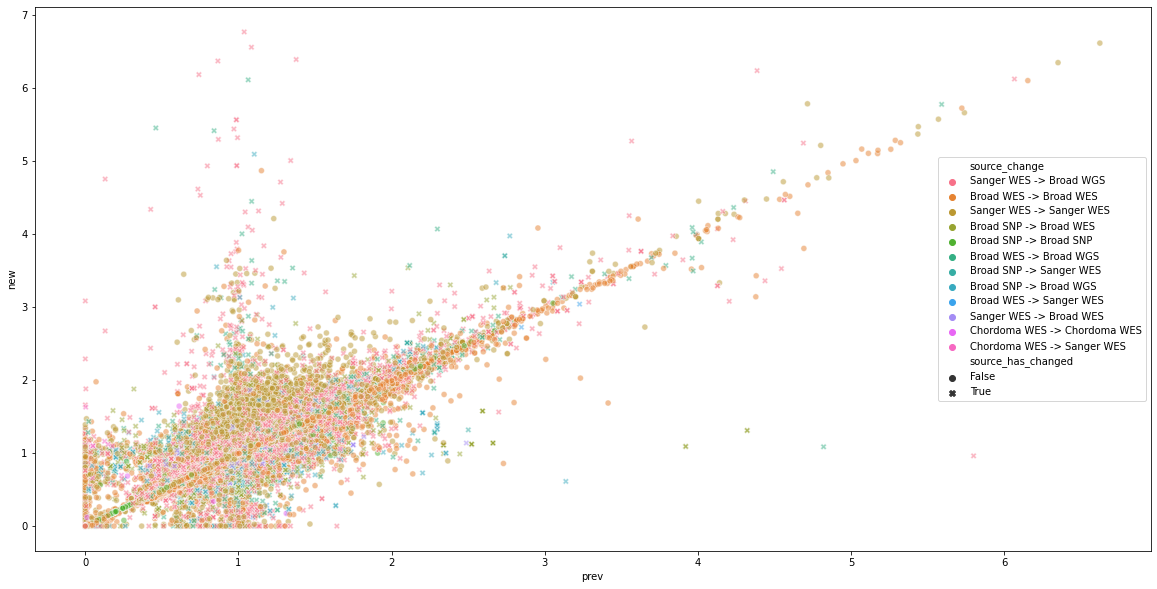

In [393]:
plotCNchanges(mergedgenecn, prevgenecn.apply(lambda x: np.log2(1+x)), mergedsegments, prevsegments)

In [394]:
if(mergedgenecn.values.max() > 100):
    print("\n\n\nTOO HIGH, not LOG2 transformed!")
if(len(mergedgenecn.index) > len(set(mergedgenecn.index))):
    print("Duplicate CL, not reprioritized well!")

In [358]:
mergedgenecn.isna().sum().sum()

177

In [373]:
rna = tc.get(name='depmap-a0ab', file='CCLE_expression_proteincoding_genes_expected_count')

In [405]:
%store -r g

In [406]:
g

,DDX11L1 (100287102),WASH7P (653635),FAM138A (645520),OR4F5 (79501),LOC729737 (729737),LOC102725121 (102725121),LOC101928626 (101928626),LOC100133331 (100133331),LOC100288069 (100288069),FAM87B (400728),...,EIF1AY (9086),RPS4Y2 (140032),PRORY (100533178),RBMY2EP (159125),TTTY13 (83868),TTTY5 (83863),RBMY2FP (159162),LOC100652931 (100652931),DAZ1 (1617),DAZ2 (57055)
ACH-001955,0.229067,0.229067,0.229067,0.229067,0.229067,0.229067,0.229067,0.229067,0.229067,0.229067,...,6.523296e-01,0.652330,0.652330,6.523296e-01,6.523296e-01,6.523296e-01,2.219084e-01,2.251392e-02,2.251392e-02,2.251392e-02
ACH-001956,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,1.565076,...,1.508193e-05,0.002215,0.001614,4.341442e-03,4.341442e-03,8.526614e-10,8.526614e-10,8.526614e-10,8.526614e-10,8.526614e-10
ACH-001957,0.383083,0.383083,0.383083,0.383083,0.383083,0.383083,0.383083,0.383083,0.383083,0.383083,...,4.999871e-09,0.002985,0.003347,7.296112e-10,7.296112e-10,7.296112e-10,7.296112e-10,7.296112e-10,7.296112e-10,7.296112e-10


In [401]:
g.index = ['ACH-001955','ACH-001956','ACH-001957']

In [402]:
rnaseqcorrelation(g.fillna(0), rna.fillna(0), ax, name="20Q4")

0 18498


ValueError: x and y must have length at least 2.

1395 18498
0.18468646870063135 18498
1311 18635
0.18918977961648076 18635


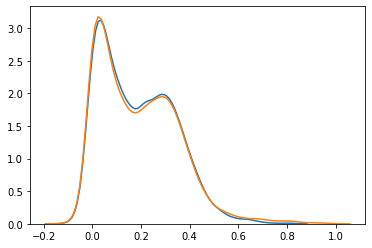

In [395]:
_, ax = plt.subplots()
rnaseqcorrelation(g.fillna(0), rna.fillna(0), ax, name="20Q4")
rnaseqcorrelation(prevgenecn[prevgenecn.index.isin(gene.index.tolist())], rna.fillna(0), ax, name="20Q3")

In [377]:
h.compareDfs(mergedgenecn, tc.get(name='depmap-a0ab', file='CCLE_gene_cn'))
#h.compareDfs(mergedsegments, tc.get(name='depmap-a0ab', file='CCLE_segment_cn'))

FOUND missmatch Columns IN df1: set()
FOUND missmatch Columns NOT IN df1: set()
FOUND missmatch Index IN df1: {'ACH-001759', 'ACH-001553', 'ACH-001758', 'ACH-001227', 'ACH-001760', 'ACH-002013', 'ACH-003210', 'ACH-001756', 'ACH-001434', 'ACH-001828', 'ACH-001686', 'ACH-002055', 'ACH-001705', 'ACH-001046', 'ACH-001707', 'ACH-002476', 'ACH-002138'}
FOUND missmatch Index NOT IN df1: {'ACH-001955', 'ACH-001957', 'ACH-001956', 'ACH-001672'}
FOUND new NAs in df1: -382635
FOUND new 0s in df1: -2539848


(set(),
 set(),
 {'ACH-001046',
  'ACH-001227',
  'ACH-001434',
  'ACH-001553',
  'ACH-001686',
  'ACH-001705',
  'ACH-001707',
  'ACH-001756',
  'ACH-001758',
  'ACH-001759',
  'ACH-001760',
  'ACH-001828',
  'ACH-002013',
  'ACH-002055',
  'ACH-002138',
  'ACH-002476',
  'ACH-003210'},
 {'ACH-001672', 'ACH-001955', 'ACH-001956', 'ACH-001957'},
 -382635,
 -2539848)

In [396]:
mergedgenecn.to_csv('temp/all_'+release+'_gene_cn.csv')
mergedsegments.to_csv('temp/all_'+release+'_segment.csv', index=False)

# uploading on taiga

## CN

In [397]:
tc.update_dataset(dataset_permaname="cn-wes-achilles-4dcd",
                 upload_file_path_dict={
            'temp/all_'+release+'_segment.csv': 'TableCSV',
            'temp/all_'+release+'_gene_cn.csv': "NumericMatrixCSV"}, 
                 changes_description="",
                  dataset_description="""
# Copy Number

Combined segment and gene-level CN calls from Broad WES, Sanger WES, and Broad SNP. Relative CN, log2(x+1) transformed.

PORTAL TEAM SHOULD NOT USE THIS: There are lines here that should not make it even to internal. Must use subsetted dataset instead. These data will not make it on the portal starting 19Q1. With the DMC portal, there is new cell line release prioritization as to which lines can be included, so a new taiga dataset will be created containing CN for the portal.

These data are generated for Achilles to pull from to run CERES.


Gene level CN data:

__Rows__: DepMap cell line IDs

__Columns__: gene names in the format HGNC\_symbol (Entrez\_ID)

Segment level data:

__Columns__: DepMap\_ID, Chromosome, Start, End, Num\_Probes, Segment\_Mean""")

Uploading all_21Q1_segment...
hitting https://cds.team/taiga/api/datafile/979ab7ada9d84e7389d959b4449f4371
Conversion and upload...:
	 Waiting in the task queue
	 Waiting in the task queue
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3

	 Done: all_21Q1_segment properly converted and uploaded
Uploading all_21Q1_gene_cn...
hitting https://cds.team/taiga/api/datafile/979ab7ada9d84e7389d959b4449f4371
Conversion and upload...:
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (l

'5fd9de45d313409f9b6a3195aba27fb0'